In [1]:
from new_model import *
from Graphing import *

c:\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_all")  # Load preloaded data
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

# Select only patch 9.3 data or later
pr_fl("Selecting 9.3 or later data...")
data_del = np.nonzero(meta[:, meta_labels.index("game_version")] < 9.03)[0]
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, data_del)
gc.collect()

rem_is = []
for i in range(len(meta)):
    if all([len(X_rec[i][j]) == 0 for j in N_PL_r]):
        rem_is.append(i)
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, rem_is)
pr_fl(len(rem_is), "no recent games samples removed")
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, Yc.shape, Yr.shape

 2019-12-19 08:08:37 Selecting 9.3 or later data...
 2019-12-19 08:08:52 701 no recent games samples removed


((87743, 27), (87743, 2250), 2250, (16, 125), (87743, 13), (87743, 160))

In [3]:
shuf_idx = load_ld("model_formats/rnn_mt_model.data", pad=False)["shuf_idx"]
meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True, indices=shuf_idx)
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, Yc.shape, Yr.shape

((87743, 27), (87743, 2250), 2250, (19, 125), (87743, 13), (87743, 160))

In [10]:
# Use only 40k samples to speed things up and prevent memory overflow
n_use = 40000
meta, X, X_rec, Yc, Yr = meta[:n_use], X[:n_use], X_rec[:n_use], Yc[:n_use], Yr[:n_use]
gc.collect()

# Extract derivative features (already done for d_all)
# X_rec_labels = add_recent_match_features(X, X_rec, X_labels, X_rec_labels)
# gc.collect()
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((40000, 27), (40000, 2250), 2250, (19, 125), 125, (40000, 13), (40000, 160))

In [12]:
meta, X, meta_labels, X_labels = clean_features(meta, X, meta_labels, X_labels)
gc.collect()
X, X_labels = filter_features(X, X_labels)
gc.collect()

0

In [28]:
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "ravg_" in l])

In [26]:
mtm_1stPass = get_recent_match_avgs(X, X_rec, X_rec_labels, pass_1="return")
gc.collect()

652386

In [66]:
# save_ld((meta, Yc, Yr, X, X_rec, X_labels, X_rec_labels, meta_labels, X_labels, Yc_labels, Yr_labels, mtm_1stPass), "why")
meta, Yc, Yr, X, X_rec, X_labels, X_rec_labels, meta_labels, X_labels, Yc_labels, Yr_labels, mtm_1stPass = load_ld("why")
gc.collect()
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((40000, 37), (40000, 921), 921, (19, 125), 125, (40000, 13), (40000, 160))

In [69]:
x_ls = []
with open('actualFinalFeatsFinalLinear.txt', 'r') as f:
    for line in f:
        x_ls.append(line.replace('[', '').replace(']', '').replace('\n', '').replace("'", '').replace(',', ''))
x_ls_X = [l for l in x_ls if "ravg_" not in l]
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if l not in x_ls_X])
gc.collect()
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((40000, 37), (40000, 838), 838, (19, 125), 125, (40000, 13), (40000, 160))

In [73]:
# Bayes-hyperoptimise momentum decay constants
dd = {}
def evaluate_momentum_hyps(c_1, c_2):
    global meta, Yc, Yr, X, X_rec, X_labels, X_rec_labels, meta_labels, X_labels, Yc_labels, Yr_labels, mtm_1stPass, x_ls, dd
    
    if (c_1, c_2) in dd:
        return dd[(c_1, c_2)]
    
#     n_val = 17743   # Exclude these (use a subset of the training samples as our hyperparameter test set)
    n_test = 10000
    n_train = 30000
#     n_train = len(X) - (n_test + n_val)
    
#     print("C1,2:", c_1, c_2)
    X_rec_avgs, X_rec_avgs_labels = get_recent_match_avgs_hypopt(X, X_rec, X_rec_labels,
                                                          c_1=c_1, c_2=c_2, pass_1=mtm_1stPass, n_jobs=n_parallel_cpu)
    gc.collect()
    X_, X_labels_ = np.hstack((X, X_rec_avgs)), X_labels + X_rec_avgs_labels
    gc.collect()
#     del X_rec
    del X_rec_avgs
    gc.collect()
    X_, X_labels_ = filter_recfeats(X_, X_labels_)
    gc.collect()
    X_, X_labels_ = remove_data_subset(X_, X_labels_, [l for l in X_labels_ if l not in x_ls])
    gc.collect()
    meta_, X_, Yc_, Yr_, Y_, X_labels_, alpha, beta, X_scales, X_scalesdict, Yr_scales, Yr_scalesdict = \
        preprocess_features(meta, X_, Yc, Yr, meta_labels, X_labels_, Yc_labels, Yr_labels, shuffle=False)
    gc.collect()

    X_train, Y_train = X_[:n_train], Y_[:n_train],
    X_test, Y_test = X_[n_train:n_train + n_test], Y_[n_train:n_train + n_test]

    m = get_model("LogisticRegression")
    if isinstance(m, MultiOutputClassifier):
        m = m.estimator
    m = Pipeline(steps=
    [
        # ('scale', StandardScaler()),
        ('scale', RobustScaler()),
        ('model', m),
    ])
    m.fit(X_train, Y_train.flatten())

    preds = m.predict(X_test) # Test accuracy
    score = np.mean(preds == Y_test.flatten()) * 100
    return score + ((0.01 * np.random.random()) - 0.005)

In [28]:
optimizer = BayesianOptimization(f=evaluate_momentum_hyps, pbounds={'c_1': (0.3, 2.0), 'c_2': (0.0, 5.0)})

In [29]:
optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   |    c_1    |    c_2    |
-------------------------------------------------
 2019-12-19 11:44:23 Scaling...
 2019-12-19 11:44:24 0.0 -204922.20366586294 965913.0 468080.64
 2019-12-19 11:44:42 0.0 -3437.0110396373084 1.0 1.0
|  1        |  66.73    |  1.027    |  1.384    |
 2019-12-19 12:10:52 Scaling...
 2019-12-19 12:10:53 0.0 -204922.31224752506 1.0 468080.64
 2019-12-19 12:11:12 0.0 -3249.7388166142164 1.0 1.0
|  2        |  67.06    |  1.864    |  4.041    |
 2019-12-19 12:39:40 Scaling...
 2019-12-19 12:39:40 0.0 -204922.3120809375 1.0 468080.64
 2019-12-19 12:40:00 0.0 -3112.6034855226585 1.0 1.0
|  3        |  67.01    |  1.212    |  4.024    |
 2019-12-19 13:08:36 Scaling...
 2019-12-19 13:08:36 0.0 -204922.19996802963 1.0 468080.64
 2019-12-19 13:08:54 0.0 -3595.790558442853 1.0 1.0
|  4        |  66.89    |  1.471    |  1.345    |
 2019-12-19 13:37:27 Scaling...
 2019-12-19 13:37:27 0.0 -204922.25158334695 1.0 468080.64
 2019-12-19 13:37:47 0.0 -3593

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


|  7        |  67.4     |  1.412    |  1.787    |
 2019-12-19 15:04:43 Scaling...
 2019-12-19 15:04:43 0.0 -204922.30782189273 1.0 468080.64
 2019-12-19 15:05:03 0.0 -3213.4051459817656 1.0 1.0
|  8        |  67.2     |  1.557    |  3.674    |
 2019-12-19 15:33:46 Scaling...
 2019-12-19 15:33:46 0.0 -204922.2709837617 1.0 468080.64
 2019-12-19 15:34:06 0.0 -3380.295957849835 1.0 1.0
|  9        |  67.16    |  1.442    |  2.353    |
 2019-12-19 16:03:35 Scaling...
 2019-12-19 16:03:35 0.0 -204922.2928999216 1.0 468080.64
 2019-12-19 16:03:53 0.0 -3410.9352052587224 1.0 1.0


c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


|  10       |  66.34    |  1.807    |  2.946    |
 2019-12-19 16:35:55 Scaling...
 2019-12-19 16:35:56 0.0 -204922.25993060123 1.0 468080.64
 2019-12-19 16:36:15 0.0 -3230.0057476807 1.0 1.0
|  11       |  67.08    |  0.8899   |  2.137    |
 2019-12-19 17:07:58 Scaling...
 2019-12-19 17:07:58 0.0 -204922.29651059682 1.0 468080.64
 2019-12-19 17:08:18 0.0 -3132.1069201091746 1.0 1.0
|  12       |  67.08    |  0.9502   |  3.083    |
 2019-12-19 17:38:54 Scaling...
 2019-12-19 17:38:54 0.0 -204922.30714779987 1.0 468080.64
 2019-12-19 17:39:15 0.0 -3024.22624193521 1.0 1.0
|  13       |  63.87    |  0.5247   |  3.628    |
 2019-12-19 18:09:06 Scaling...
 2019-12-19 18:09:06 0.0 -204922.2835562771 1.0 468080.64
 2019-12-19 18:09:27 0.0 -3194.087783704212 1.0 1.0
|  14       |  67.14    |  1.035    |  2.655    |
 2019-12-19 18:38:32 Scaling...
 2019-12-19 18:38:32 0.0 -204922.31612489448 1.0 468080.64
 2019-12-19 18:38:50 0.0 -3125.6020303117834 1.0 1.0
|  15       |  66.99    |  1.515    |

c:\python36\lib\site-packages\joblib\externals\loky\process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [ ]:
optimizer = BayesianOptimization(f=evaluate_momentum_hyps, pbounds={'c_1': (1.0, 2.0), 'c_2': (1.0, 2.0)})

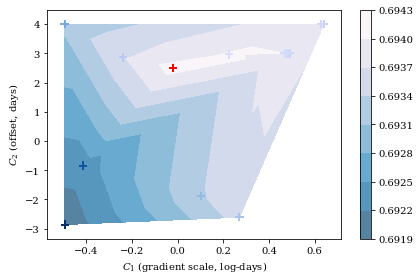

In [5]:
data_list = [
    [  0.6937   , -0.2391   ,  2.863     ],
    [  0.6934   ,  0.1023   , -1.878     ],
    [  0.6924   , -0.4161   , -0.8388    ],
    [  0.6941   , -0.02021  ,  2.512     ],
    [  0.6935   ,  0.2699   , -2.609     ],
    [  0.6939   ,  0.4841   ,  2.984     ],
    [  0.694    ,  0.2243   ,  2.963     ],
    [  0.692    , -0.4946   , -2.859     ],
    [  0.6939   ,  0.4904   ,  2.997     ],
    [  0.6937   ,  0.6405   ,  4.0       ],
    [  0.6932   , -0.4961   ,  4.0       ],
    [  0.6939   ,  0.6296   ,  3.999     ],
]
data_list = [[a["target"], a['params']["c_1"], a['params']["c_2"]] for a in \
 [{'target': 0.6936755345433119,
   'params': {'c_1': -0.23910213247833678, 'c_2': 2.8632363578190096}},
  {'target': 0.6933749966657297,
   'params': {'c_1': 0.1023424306111752, 'c_2': -1.8782666291796972}},
  {'target': 0.692350629795401,
   'params': {'c_1': -0.4160877590081161, 'c_2': -0.8387838511347478}},
  {'target': 0.6941251072238122,
   'params': {'c_1': -0.020205780521248662, 'c_2': 2.5119217359648323}},
  {'target': 0.6935248204995978,
   'params': {'c_1': 0.2699259269669396, 'c_2': -2.6093983320735674}},
  {'target': 0.6939252795944494,
   'params': {'c_1': 0.48410467633095156, 'c_2': 2.984429313280347}},
  {'target': 0.6940251301230335,
   'params': {'c_1': 0.22427816349628704, 'c_2': 2.963326706789017}},
  {'target': 0.6919755418433273,
   'params': {'c_1': -0.4946256472265267, 'c_2': -2.8591573537025754}},
  {'target': 0.6938747347298561,
   'params': {'c_1': 0.4903840798235878, 'c_2': 2.9968851810483237}},
  {'target': 0.6939999039150013,
   'params': {'c_1': 0.4679987158635178, 'c_2': 2.9992088919370143}},
  {'target': 0.6939751796460903,
   'params': {'c_1': 0.4803186511388662, 'c_2': 2.9969729918835455}},
  {'target': 0.6937497282093978,
   'params': {'c_1': 0.6405061160493399, 'c_2': 3.9996977503651605}},
  {'target': 0.6931748986423335,
   'params': {'c_1': -0.4960785572143785, 'c_2': 3.9995969711685833}},
  {'target': 0.693875372454942,
   'params': {'c_1': 0.6295599585704277, 'c_2': 3.9992354283722316}},
  {'target': 0.693925308984014,
   'params': {'c_1': 0.6262318837062448, 'c_2': 3.9989203392016375}}]
]
data_list_full = data_list + [
]
data = np.asarray(data_list)
data_full = np.asarray(data_list_full)
# data += (np.random.random(data.shape) * 0.00001)
x, y, z = data[:,1], data[:,2], data[:,0]
x_,y_,z_= data_full[:,1], data_full[:,2], data_full[:,0]
# data = pd.DataFrame(data={'x':x, 'y':y, 'z':z})
# data = data.pivot(index='x', columns='y', values='z')
# plt.show()
a = 0.9       # color constants
b = 0.67
# Get the colormap colors, multiply them with the factor "a", and create new colormap
my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
my_cmap = my_cmap[::-1]
my_cmap[:,0:2] *= a
my_cmap = ListedColormap(my_cmap)
pubu = plt.cm.PuBu(np.arange(plt.cm.PuBu.N))
pubu = pubu[::-1]
pubu = 1 - pubu
pubu *= b
pubu = 1 - pubu
pubu = ListedColormap(pubu)
clrmap = "PuBu" + '_r'
plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=pubu)
# plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=plt.get_cmap(clrmap))
plt.xlabel("$C_1$ (gradient scale, log-days)")
plt.ylabel("$C_2$ (offset, days)")
# plt.title("Bayesian hyperparameter optimisation of momentum constants")
plt.colorbar()
# plt.scatter(x, y, c=z, cmap=plt.get_cmap("Blues_r"), marker='+', alpha=1.0, s=70, lw=2)
plt.scatter(x, y, c=z, cmap=my_cmap, marker='+', alpha=1.0, s=70, lw=2)
max_i = np.argmax(z)
max_x, max_y = x[max_i], y[max_i]
plt.scatter([max_x], [max_y], color="red", marker='+', alpha=1.0, s=70, lw=2)
# plt.annotate("67.4", (max_x + 0.05, max_y + 0.05))
plt.tight_layout()
# plt.savefig(graphs_folder  + "bayopt.pdf", filetype="pdf")
plt.show()

In [ ]:
data_list = [
    [  0.6937   , -0.2391   ,  2.863     ],
    [  0.6934   ,  0.1023   , -1.878     ],
    [  0.6924   , -0.4161   , -0.8388    ],
    [  0.6941   , -0.02021  ,  2.512     ],
    [  0.6935   ,  0.2699   , -2.609     ],
    [  0.6939   ,  0.4841   ,  2.984     ],
    [  0.694    ,  0.2243   ,  2.963     ],
    [  0.692    , -0.4946   , -2.859     ],
    [  0.6939   ,  0.4904   ,  2.997     ],
]
data_list_full = data_list + [
]
data = np.asarray(data_list)
data_full = np.asarray(data_list_full)
# data += (np.random.random(data.shape) * 0.00001)
x, y, z = data[:,1], data[:,2], data[:,0]
x_,y_,z_= data_full[:,1], data_full[:,2], data_full[:,0]
# data = pd.DataFrame(data={'x':x, 'y':y, 'z':z})
# data = data.pivot(index='x', columns='y', values='z')
# plt.show()
a = 0.9       # color constants
b = 0.67
# Get the colormap colors, multiply them with the factor "a", and create new colormap
my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
my_cmap = my_cmap[::-1]
my_cmap[:,0:2] *= a
my_cmap = ListedColormap(my_cmap)
pubu = plt.cm.PuBu(np.arange(plt.cm.PuBu.N))
pubu = pubu[::-1]
pubu = 1 - pubu
pubu *= b
pubu = 1 - pubu
pubu = ListedColormap(pubu)
clrmap = "PuBu" + '_r'
plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=pubu)
# plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=plt.get_cmap(clrmap))
plt.xlabel("$C_1$ (gradient scale, log-days)")
plt.ylabel("$C_2$ (offset, days)")
# plt.title("Bayesian hyperparameter optimisation of momentum constants")
plt.colorbar()
# plt.scatter(x, y, c=z, cmap=plt.get_cmap("Blues_r"), marker='+', alpha=1.0, s=70, lw=2)
plt.scatter(x, y, c=z, cmap=my_cmap, marker='+', alpha=1.0, s=70, lw=2)
max_i = np.argmax(z)
max_x, max_y = x[max_i], y[max_i]
plt.scatter([max_x], [max_y], color="red", marker='+', alpha=1.0, s=70, lw=2)
# plt.annotate("67.4", (max_x + 0.05, max_y + 0.05))
plt.tight_layout()
# plt.savefig(graphs_folder  + "bayopt.pdf", filetype="pdf")
plt.show()

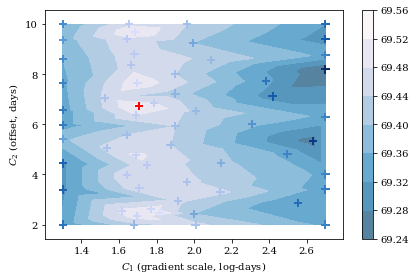

In [9]:
data_list = [
    [  69.45    ,  2.145    ,  4.452    ],
    [  69.26    ,  2.635    ,  5.332    ],
    [  69.35    ,  2.497    ,  4.81     ],
    [  69.33    ,  2.384    ,  7.741    ],
    [  69.41    ,  2.145    ,  4.452    ],
    [  69.3     ,  2.418    ,  7.114    ],
    [  69.35    ,  2.7      ,  4.0      ],
    [  69.44    ,  1.9      ,  8.0      ],
    [  69.44    ,  1.9      ,  5.927    ],
    [  69.42    ,  1.9      ,  7.226    ],
    [  69.36    ,  1.3      ,  10.0     ],
    [  69.33    ,  1.3      ,  2.0      ],
    [  69.35    ,  2.7      ,  2.0      ],
    [  69.39    ,  1.3      ,  5.427    ],
    [  69.32    ,  2.7      ,  10.0     ],
    [  69.36    ,  1.3      ,  8.609    ],
    [  69.45    ,  1.915    ,  2.95     ],
    [  69.31    ,  1.3      ,  3.397    ],
    [  69.34    ,  1.3      ,  6.576    ],
    [  69.4     ,  1.994    ,  9.241    ],
    [  69.32    ,  2.554    ,  2.872    ],
    [  69.45    ,  2.008    ,  2.0      ],
    [  69.44    ,  1.961    ,  10.0     ],
    [  69.52    ,  1.816    ,  2.469    ],
    [  69.49    ,  1.615    ,  2.558    ],
    [  69.4     ,  2.0      ,  2.426    ],
    [  69.35    ,  2.7      ,  8.766    ],
    [  69.31    ,  1.3      ,  4.443    ],
    [  69.35    ,  1.3      ,  7.635    ],
    [  69.45    ,  1.963    ,  3.693    ],
    [  69.44    ,  1.875    ,  5.176    ],
    [  69.35    ,  2.7      ,  6.297    ],
    [  69.38    ,  1.3      ,  9.372    ],
    [  69.43    ,  2.009    ,  6.526    ],
    [  69.43    ,  2.089    ,  8.562    ],
    [  69.34    ,  2.7      ,  3.399    ],
    [  69.43    ,  1.679    ,  2.0      ],
    [  69.3     ,  2.7      ,  9.415    ],
    [  69.34    ,  1.3      ,  5.974    ],
    [  69.47    ,  1.642    ,  3.966    ],
    [  69.52    ,  1.684    ,  9.689    ],
    [  69.24    ,  2.7      ,  8.19     ],
    [  69.37    ,  2.309    ,  6.022    ],
    [  69.47    ,  1.682    ,  8.813    ],
    [  69.46    ,  1.664    ,  8.363    ],
    [  69.49    ,  1.692    ,  4.77     ],
    [  69.47    ,  1.709    ,  3.455    ],
    [  69.5     ,  1.696    ,  2.33     ],
    [  69.47    ,  1.653    ,  10.0     ],
    [  69.45    ,  1.536    ,  5.048    ],
    [  69.47    ,  1.644    ,  9.413    ],
    [  69.47    ,  1.748    ,  4.366    ],
    [  69.45    ,  1.526    ,  7.059    ],
    [  69.44    ,  1.64     ,  5.575    ],
    [  69.5     ,  1.769    ,  2.617    ],
    [  69.45    ,  2.14     ,  3.29     ],
    [  69.48    ,  1.692    ,  6.362    ],
    [  69.53    ,  1.706    ,  6.749    ],
    [  69.48    ,  1.787    ,  6.863    ],
    [  69.51    ,  1.698    ,  7.643    ],
]
data_list_full = data_list + [
]
data = np.asarray(data_list)
data_full = np.asarray(data_list_full)
# data += (np.random.random(data.shape) * 0.00001)
x, y, z = data[:,1], data[:,2], data[:,0]
x_,y_,z_= data_full[:,1], data_full[:,2], data_full[:,0]
# data = pd.DataFrame(data={'x':x, 'y':y, 'z':z})
# data = data.pivot(index='x', columns='y', values='z')
# plt.show()
a = 0.9       # color constants
b = 0.67
# Get the colormap colors, multiply them with the factor "a", and create new colormap
my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
my_cmap = my_cmap[::-1]
my_cmap[:,0:2] *= a
my_cmap = ListedColormap(my_cmap)
pubu = plt.cm.PuBu(np.arange(plt.cm.PuBu.N))
pubu = pubu[::-1]
pubu = 1 - pubu
pubu *= b
pubu = 1 - pubu
pubu = ListedColormap(pubu)
clrmap = "PuBu" + '_r'
plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=pubu)
# plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=plt.get_cmap(clrmap))
plt.xlabel("$C_1$ (gradient scale, log-days)")
plt.ylabel("$C_2$ (offset, days)")
# plt.title("Bayesian hyperparameter optimisation of momentum constants")
plt.colorbar()
# plt.scatter(x, y, c=z, cmap=plt.get_cmap("Blues_r"), marker='+', alpha=1.0, s=70, lw=2)
plt.scatter(x, y, c=z, cmap=my_cmap, marker='+', alpha=1.0, s=70, lw=2)
max_i = np.argmax(z)
max_x, max_y = x[max_i], y[max_i]
plt.scatter([max_x], [max_y], color="red", marker='+', alpha=1.0, s=70, lw=2)
# plt.annotate("67.4", (max_x + 0.05, max_y + 0.05))
plt.tight_layout()
# plt.savefig(graphs_folder  + "bayopt.pdf", filetype="pdf")
plt.show()

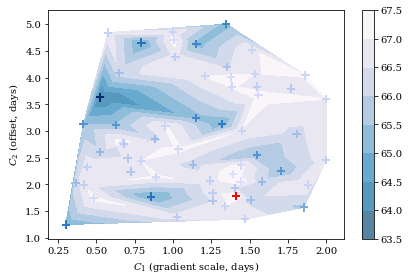

In [260]:
# import seaborn as sns
data_list = [
    
    [  66.73    ,  1.027    ,  1.384    ],
    [  67.06    ,  1.864    ,  4.041    ],
    [  67.01    ,  1.212    ,  4.024    ],
    [  66.89    ,  1.471    ,  1.345    ],
    [  66.99    ,  1.882    ,  1.996    ],
    [  67.4     ,  1.412    ,  1.787    ],
    [  67.2     ,  1.557    ,  3.674    ],
    [  67.16    ,  1.442    ,  2.353    ],
    [  66.34    ,  1.807    ,  2.946    ],
    [  67.08    ,  0.8899   ,  2.137    ],
    [  67.08    ,  0.9502   ,  3.083    ],
    [  63.87    ,  0.5247   ,  3.628    ],
    [  67.14    ,  1.035    ,  2.655    ],
    [  66.99    ,  1.515    ,  4.523    ],
    [  65.02    ,  1.32     ,  3.135    ],
    [  67.3     ,  0.6655   ,  2.781    ],
    [  66.99    ,  1.534    ,  4.069    ],
    [  67.01    ,  2.0      ,  3.603    ],
    [  66.83    ,  1.242    ,  2.068    ],
    [  66.88    ,  0.4414   ,  2.319    ],
    [  66.78    ,  2.0      ,  2.456    ],
    [  67.17    ,  0.4847   ,  1.738    ],
    [  67.25    ,  1.006    ,  4.708    ],
    [  65.24    ,  1.348    ,  5.0      ],
    [  66.72    ,  1.016    ,  4.386    ],
    [  66.9     ,  0.575    ,  4.842    ],
    [  65.05    ,  0.3      ,  1.246    ],
    [  65.86    ,  1.854    ,  1.567    ],
    [  64.91    ,  0.8586   ,  1.77     ],
    [  66.99    ,  0.7918   ,  2.443    ],
    [  66.2     ,  1.582    ,  2.051    ],
    [  66.29    ,  1.13     ,  2.369    ],
    [  66.24    ,  0.8812   ,  2.849    ],
    [  66.65    ,  1.77     ,  3.794    ],
    [  66.12    ,  0.5232   ,  2.607    ],
    [  67.0     ,  1.339    ,  1.585    ],
    [  67.05    ,  1.385    ,  3.831    ],
    [  66.87    ,  0.4172   ,  1.995    ],
    [  67.33    ,  1.441    ,  2.052  ],
    [  66.33    ,  1.507    ,  1.711    ],
    [  66.97    ,  1.45     ,  3.001    ],
    [  65.46    ,  1.55     ,  2.551 ],
    [  66.6     ,  0.7041   ,  2.486 ],
    [  65.54    ,  0.6274   ,  3.115    ],
    [  65.28    ,  1.152    ,  3.245    ],
    [  65.52    ,  1.703    ,  2.249    ],
    [  65.47    ,  0.4156   ,  3.132    ],
    [  66.74    ,  1.258    ,  1.835    ],
    [  64.92    ,  0.7935   ,  4.656    ],
    [  66.55    ,  1.406    ,  1.922    ],
    [  67.32    ,  1.391    ,  2.189    ],
    [  65.25    ,  1.153    ,  4.63     ],
    [  66.8     ,  1.547    ,  3.83     ],
    [  67.2     ,  1.378    ,  4.001    ],
    [  66.95    ,  0.9982   ,  4.859    ],
    [  66.53    ,  0.7231   ,  2.238    ],
    [  66.42    ,  1.354    ,  4.192    ],
    [  66.34    ,  0.65     ,  4.088    ],
    [  66.49    ,  1.259    ,  1.683    ],
    [  66.29    ,  0.3647   ,  2.029    ],
    [  66.66    ,  0.6809   ,  2.764    ],

#     [  67.3     ,  1.441    ,  2.052    ],  # slightly redundant
#     [  67.19    ,  1.445    ,  2.054    ],
#     [  66.71    ,  1.44     ,  2.058    ],
#     [  67.37    ,  1.417    ,  1.784    ],
#     [  67.03    ,  1.416    ,  1.79     ],
#     [  65.05    ,  1.413    ,  2.119    ],

#     [  66.39    ,  1.393    ,  1.774    ],  # redundant
#     [  67.13    ,  1.42     ,  1.767    ],
#     [  67.28    ,  1.449    ,  2.031    ],
#     [  64.33    ,  1.466    ,  2.05     ],
#     [  67.12    ,  1.435    ,  2.038    ],
#     [  67.01    ,  1.383    ,  2.204    ],
#     [  67.21    ,  1.428    ,  2.062    ],
#     [  67.16    ,  1.442    ,  2.013    ],
#     [  67.37    ,  1.408    ,  2.202    ],
#     [  66.58    ,  1.409    ,  2.182    ],
#     [  66.33    ,  1.405    ,  2.225    ],
    
#     [  51.24    ,  2.0      ,  0.0      ], # outliers / edges
#     [  50.15    ,  0.3101   ,  1.791    ],
# |  62       |  50.73    |  0.75     |  1.0      |
# |  63       |  50.74    |  1.5      |  1.0      |
# |  76       |  63.07    |  1.912    |  1e+03    |
    
    
]
data_list_full = data_list + [
]
data = np.asarray(data_list)
data_full = np.asarray(data_list_full)
# data += (np.random.random(data.shape) * 0.00001)
x, y, z = data[:,1], data[:,2], data[:,0]
x_,y_,z_= data_full[:,1], data_full[:,2], data_full[:,0]
# data = pd.DataFrame(data={'x':x, 'y':y, 'z':z})
# data = data.pivot(index='x', columns='y', values='z')
# cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
# # sns.heatmap(flights_missing, cmap=cmap)
# sns.heatmap(data, square=True, robust=True)
# plt.show()
a = 0.9
b = 0.67
# Get the colormap colors, multiply them with the factor "a", and create new colormap
from matplotlib.colors import ListedColormap
my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
my_cmap = my_cmap[::-1]
my_cmap[:,0:2] *= a
my_cmap = ListedColormap(my_cmap)
pubu = plt.cm.PuBu(np.arange(plt.cm.PuBu.N))
pubu = pubu[::-1]
pubu = 1 - pubu
pubu *= b
pubu = 1 - pubu
pubu = ListedColormap(pubu)
clrmap = "PuBu" + '_r'
plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=pubu)
# plt.tricontourf(x, y, z, norm=plt.cm.colors.Normalize(), cmap=plt.get_cmap(clrmap))
plt.xlabel("$C_1$ (gradient scale, days)")
plt.ylabel("$C_2$ (offset, days)")
# plt.title("Bayesian hyperparameter optimisation of momentum constants")
plt.colorbar()
# plt.scatter(x, y, c=z, cmap=plt.get_cmap("Blues_r"), marker='+', alpha=1.0, s=70, lw=2)
plt.scatter(x, y, c=z, cmap=my_cmap, marker='+', alpha=1.0, s=70, lw=2)
max_i = np.argmax(z)
max_x, max_y = x[max_i], y[max_i]
plt.scatter([max_x], [max_y], color="red", marker='+', alpha=1.0, s=70, lw=2)
# plt.annotate("67.4", (max_x + 0.05, max_y + 0.05))
plt.tight_layout()
# plt.savefig(graphs_folder  + "bayopt.pdf", filetype="pdf")
plt.show()

In [ ]:
### dd = {(x, y): z for (z, x, y) in data_list}

In [76]:
optimizer = BayesianOptimization(f=evaluate_momentum_hyps, pbounds={'c_1': (0.3, 2.0), 'c_2': (0.3, 5.0)})

In [ ]:
for (z, x, y) in data_list:
    optimizer.probe(params={"c_1": x, "c_2": y}, lazy=True)
optimizer.probe(params={"c_1": 1.440713777, "c_2": 2.0517737}, lazy=True)
optimizer.probe(params={"c_1": 1.507373737, "c_2": 1.7110777}, lazy=True)
optimizer.probe(params={"c_1": 1.450109145, "c_2": 3.0013140}, lazy=True)
optimizer.probe(params={"c_1": 1.550109145, "c_2": 2.5513140}, lazy=True)
optimizer.maximize(init_points=0, n_iter=50)

|   iter    |  target   |    c_1    |    c_2    |
-------------------------------------------------
|  1        |  66.73    |  1.027    |  1.384    |
|  2        |  67.06    |  1.864    |  4.041    |
|  3        |  67.01    |  1.212    |  4.024    |
|  4        |  66.89    |  1.471    |  1.345    |
|  5        |  66.99    |  1.882    |  1.996    |
|  6        |  67.4     |  1.412    |  1.787    |
|  7        |  67.2     |  1.557    |  3.674    |
|  8        |  67.16    |  1.442    |  2.353    |
|  9        |  66.34    |  1.807    |  2.946    |
|  10       |  67.08    |  0.8899   |  2.137    |
|  11       |  67.08    |  0.9502   |  3.083    |
|  12       |  63.87    |  0.5247   |  3.628    |
|  13       |  67.14    |  1.035    |  2.655    |
|  14       |  66.99    |  1.515    |  4.523    |
|  15       |  65.02    |  1.32     |  3.135    |
|  16       |  67.3     |  0.6655   |  2.781    |
|  17       |  66.99    |  1.534    |  4.069    |
|  18       |  67.01    |  2.0      |  3.603    |
